# Daniel Ochoa : Final
### Not:  Before running install both kmodes and plotly

In [18]:
## NUMPY, PANDAS, MATPLOTLIB
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
## PLOTLY
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
## For offline plotting
init_notebook_mode(connected=True)
## KMODES
from kmodes.kmodes import KModes

## DATA PREPARATION

In [2]:
data_survey = pd.read_csv("multipleChoiceResponses.csv", low_memory=False)

In [3]:
# Drop from question Q11 onwards because those questions were
# not answered by more than 50% of the people that 
# took the survey

# I also drop the Q10 question as it would rule out
# the people that are not employed and the Time
# taken to answer the survey
data_survey = data_survey.iloc[:,1:13]
print("Remaining Questions:", data_survey.columns)

Remaining Questions: Index(['Q1', 'Q1_OTHER_TEXT', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q6_OTHER_TEXT',
       'Q7', 'Q7_OTHER_TEXT', 'Q8', 'Q9'],
      dtype='object')


In [4]:
# Dropping the aclaratory answers related with a multiple choice
# question i.e Q1_OTHER_TEXT, Q6_OTHER_TEXT...

# Define a set of the questions to be dropped
q_drop_set = {'Q1_OTHER_TEXT', 'Q6_OTHER_TEXT', 'Q7_OTHER_TEXT'}

# Get the complete set of questions
q_current_set = set(data_survey.columns)

# Get the remaining list of questions by
# using set operations ("-")
q_remaining_list = sorted(list(q_current_set - q_drop_set))

# Index the dataframe with the obtained list of
# questions
data_survey = data_survey[q_remaining_list].dropna()

# No headers
data_survey_nq = data_survey.iloc[1:,:]
data_survey.head(5)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9
0,What is your gender? - Selected Choice,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,In what industry is your current employer/cont...,How many years of experience do you have in yo...,What is your current yearly compensation (appr...
2,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,"10-20,000"
3,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,"0-10,000"
5,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,"0-10,000"
6,Male,25-29,Colombia,Bachelor’s degree,Physics or astronomy,Data Scientist,Computers/Technology,0-1,I do not wish to disclose my approximate yearl...


## VISUALIZATION

I used this activity as a an opportunity to learn about an alternative visualization tool: Plotly. It uses javascript plotting libraries to render interactive plots in the browser which sometimes can be richer than the ones obtained with plain matplotlib.
https://plot.ly/python/

### Visualizing the number of entries per country

#### Count the number of entries per country, get gender and carrer level percentages

In [5]:
from collections import Counter
data_country = data_survey_nq["Q3"].values
entries_by_country = Counter(data_country)

# Create a dataframe from the dictionary object Counter
df_entry_by_country = pd.DataFrame()
df_entry_by_country["country"] = entries_by_country.keys()
df_entry_by_country["count"] = entries_by_country.values()

def count_ocurr_country(df, country_name, key, key_value):
    df_country = df[df["Q3"] == country_name]
    df_keys = df_country[df_country[key] == key_value]
    return df_keys.shape[0]

# GENDER
for key in ["Male", "Female"]:
    df_entry_by_country[key] = df_entry_by_country.apply(
                                        lambda x: count_ocurr_country(data_survey_nq, x["country"],"Q1", key),
                                        axis = 1
                                    )
    
df_entry_by_country["other_gender"] = df_entry_by_country.apply(
                                    lambda x: (x["count"] - x["Male"] - x["Female"]), axis = 1 )

# CARRER LEVEL
df_entry_by_country["ProfBach"] = df_entry_by_country.apply(
                                    lambda x: count_ocurr_country(data_survey_nq, x["country"], "Q4", "Bachelor’s degree")+\
                                    count_ocurr_country(data_survey_nq, x["country"], "Q4", "Professional degree"),                                        
                                    axis = 1)

for key in ["Master’s degree", "Doctoral degree"]:
    df_entry_by_country[key] = df_entry_by_country.apply(
                                        lambda x: count_ocurr_country(data_survey_nq, 
                                                                                     x["country"], 
                                                                                     "Q4",
                                                                                     key), axis = 1)
df_entry_by_country["other_career"] = df_entry_by_country.apply(
                                    lambda x: (x["count"] - x["Master’s degree"] - x["Doctoral degree"]-\
                                                x["ProfBach"]), axis = 1 )

for key in ["Male", "Female", "other_gender", "Master’s degree", "Doctoral degree", "ProfBach", "other_career"]:
    df_entry_by_country[key] =  df_entry_by_country.apply(lambda x: x[key]*100/x["count"], axis = 1 )

df_entry_by_country = df_entry_by_country.round(2)

# Replace some names so that a future conversion
# to country codes does not have problems
dict_replace_names = {'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
                     'United States of America':'United States',
                     'Iran, Islamic Republic of...':'Iran',
                     'Hong Kong (S.A.R.)':'Hong Kong',
                     'South Korea': 'Korea, South',
                     'Republic of Korea': 'Korea, North',
                     'Viet Nam': 'Vietnam'}
df_entry_by_country = df_entry_by_country.replace(dict_replace_names)

# Remove the country entries that are not disclosed or listed.
df_entry_by_country = df_entry_by_country[~df_entry_by_country["country"].isin(["Other", "I do not wish to disclose my location"])]



#### Associate country codes to the names for plotting

In [6]:
# Download plotly data containing country-code relations
df_country_code = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
country_names = df_country_code["COUNTRY"].values
country_code = df_country_code["CODE"].values

# Create dictionary to easy access of code by indexing with the country name
dict_country_code = {key: value for (key, value) in zip(country_names, country_code)}

# Create an empty column in the df_entry_by_country dataframe
# then fill it with the codes in dict_country_code
df_entry_by_country["code"] = df_entry_by_country.apply(lambda x: dict_country_code[x["country"]], axis = 1)

#### Specify the data and layout for the Plotly graphic

In [7]:
df_entry_by_country["text"] = df_entry_by_country['country'].astype(str) +"<br>"+\
                              "Entries by Gender:"+"<br>"+\
                              "  *Female: "+ df_entry_by_country["Female"].astype(str)+"%<br>"+\
                              "  *Male: "+ df_entry_by_country["Male"].astype(str)+"%<br>"+\
                              "  *Other: "+ df_entry_by_country["other_gender"].astype(str) + "%<br>"+\
                              "Entries by Carrer:"+"<br>"+\
                              "  *Bachelor-Professional: "+ df_entry_by_country["ProfBach"].astype(str)+"%<br>"+\
                              "  *Master's: "+ df_entry_by_country["Master’s degree"].astype(str)+"%<br>"+\
                              "  *Doctoral: "+ df_entry_by_country["Doctoral degree"].astype(str) + "%<br>"+\
                              "  *Other: "+ df_entry_by_country["other_career"].astype(str) + "%<br>"
    
                                
data = [ dict(
        type = 'choropleth',
        locations = df_entry_by_country['code'],
        z = df_entry_by_country['count'],
        text = df_entry_by_country['text'],
        autocolorscale = True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = True,
            title = 'Number of Entries'),
      ) ]

layout = dict(
    title = 'Kaggle 2018 Survey',  
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'natural earth'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot(fig, validate=False, filename='d3-world-map' )

The obtained graphics from Plotly are interactive. For the obtained map plot, you can drag it, zoom in and zoom out and obtain information from the number of entriesin addition to some percentages regarding the gender and career level for each country by hovering over the country of interest.

In order to visualize better the extracted percentages related with the gender and carreer level I decided to choose four countries: Colombia, Canada, USA and India. The latter 2 because they are the countries with the most entries in the survey, as can be seen in the above presented map, the second one out of personal interest and the first one because is my natal country.

#### Gender proportion data for Colombia, Canada, United States and India

In [8]:
country_names = ["Colombia", "Canada", "United States", "India"]

def plot_donuts_country(df, countries, labels, label_display, title):
    
    fig_rates = tools.make_subplots(rows = 2, cols = 2);
    dict_data = {key: None for key in country_names}
    for country_name in countries:
        values = []
        for label in labels:
            values.append((df[df["country"] == country_name][label]).values[0])
        dict_data[country_name] = values
        
    x_pos = [[0, .48], [.52, 1], [0, .48], [.52, 1]]
    y_pos = [[0, .49], [0, .49], [.51, 1], [.51, 1]]
    data = [{'labels': label_display,
             'values': dict_data[country_name],
             'type': 'pie',
             'name': country_name,
             'text':[country_name],
             'textposition':"inside",
             'hoverinfo':"label+name",
             "hole": .4,
             'domain': {'x': x_pos[idx], 'y': y_pos[idx]}
            } for idx, country_name in enumerate(country_names)]

    layout = {"title": title,
              "showlegend": True
             }

    fig = {"data": data, "layout": layout}
    py.iplot(fig, filename = 'pie_chart_subplots')
    
gender_labels = ["Male", "Female", "other_gender"]
gender_labels_display = ["Male", "Female", "Other"]
    
plot_donuts_country(df_entry_by_country, country_names, gender_labels, gender_labels_display,
            "Gender proportions by country")

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



The trend is clear for the studied countries in what gender respects. The bulk of the population that answered the survey is male with Canada and United States having a slightly higher portion of female entries in comparison to India and Colombia.

#### Education level proportion data for Colombia, Canada, United States and India

In [17]:
career_labels = ["ProfBach", "Master’s degree", "Doctoral degree", "other_career"]
career_labels_display = ["Professional - Bachelor's Degree", "Master's Degree", "Doctoral Degree", "Other"]
plot_donuts_country(df_entry_by_country, country_names, career_labels, career_labels_display,
            "Education Level proportions by country")

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



With this pie charts one can observe the carrer level proportions for each studied country. While comparing Colombia and USA it can be seen that the proportion of people with master's degree is similar but that of the people with doctoral degree in Colombia is half of the one seen for USA. Although the number of people that answered the survey in Colombia could not make a representative sample, the difference in doctoral degree proportion could be explained by the mere fact that this education level is not promoted neither by the country nor society in general within the country.

## CLUSTERING

Now I study the yearly compensation in relation with the gender, education level and major. To do so I use the Kmodes algorithm described in *Huang, Z.: Clustering large data sets with mixed numeric and categorical values, Proceedings of the First Pacific Asia Knowledge Discovery and Data Mining Conference, Singapore, pp. 21-34, 1997* and implemented in the kmodes-python library (https://github.com/nicodv/kmodes).

This uses a similarity measure instead of the usual Euclidean measure used in K-means in order to handle categorical data. The similarity is, in broad terms, calculated for each element by checking wether or not the categorical value of the element is the same as the mode of the associated feature in a given cluster. If it is, the similarity measure is increased, otherwise it is kept unchanged. The procedure is repeated for each categorical feature associated with the element. The rest of the procedure to obtain the clusters is similar to the one of K-means.

In [10]:
keys = ["Q1", "Q4", "Q5", "Q9"]
data_comp = data_survey_nq[keys]

# Remove entries that do not disclose yearly compensation
dict_replace_compensation = {"I do not wish to disclose my approximate yearly compensation": np.nan}
data_comp = data_comp.replace(dict_replace_compensation).dropna().values

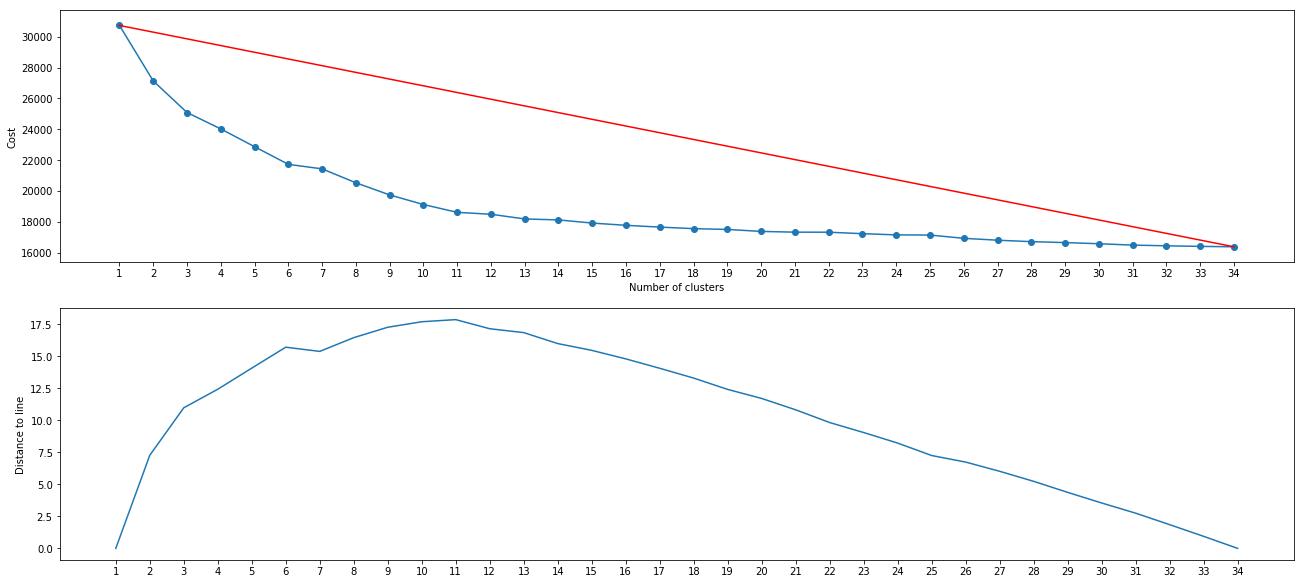

In [11]:
def score_k_modes(X, sizes, max_iter):
    scores = np.zeros(len(sizes))
    
    for id_size, size in enumerate(sizes):
        scores_size = []
        km = KModes(n_clusters = size, max_iter = max_iter)
        km.fit(X)
        scores[id_size] = km.cost_
    return scores

def plot_score_k_modes(X, size_min, size_max, step = 1, max_iter = 300):
    assert size_max > size_min, "size_max must be greater than size_min"
    sizes = range(size_min, size_max, step)
    scores =  score_k_modes(X, sizes, max_iter)
    
    fig, axs = plt.subplots(2, 1, figsize = (18, 8), constrained_layout = True)
    axs[0].plot(sizes, scores)
    axs[0].scatter(sizes, scores)
    axs[0].set_ylabel("Cost")
    axs[0].set_xlabel("Number of clusters")
    axs[0].set_xticks(sizes)
    line_domain = np.linspace(sizes[0], sizes[-1])
    y_line = (scores[-1] - scores[0])/(sizes[-1] - sizes[0])*(line_domain - line_domain[0]) +\
                scores[0]
    axs[0].plot(line_domain, y_line, c = 'r')
    
    
    def distance_to_line(x0, y0, x1, y1, x2, y2):
        """
        Calculates the distance from (x0,y0) to the 
        line defined by (x1,y1) and (x2,y2)
        Based on:
        https://www.linkedin.com/pulse/finding-optimal-number-clusters-k-means-through-elbow-asanka-perera/
        https://medium.com/@joao.figueira/what-is-k-ddf36926a752
        """
        dx = x2 - x1
        dy = y2 - y1
        return abs(dy * x0 - dx * y0 + x2 * y1 - y2 * x1) / \
               np.sqrt(dx * dx + dy * dy)

    distances_to_line = [distance_to_line(x, y, sizes[0], scores[0],
                                          sizes[-1], scores[-1]) for x, y in zip(sizes, list(scores))]
    axs[1].plot(sizes, distances_to_line)
    axs[1].set_ylabel("Distance to line")
    axs[1].set_xticks(sizes)
    
plot_score_k_modes(data_comp, 1, 35 , step = 1)

Here I extract the "optimal" number of clusters found with K-modes. In order to do so I calculate the distances from the cost (related to the similarity measure) found for each number of clusters to a line going from the first to the last value of the cost optimized by the K-modes algorithm. The "optimal" found number is 11. 

In [19]:
n_clusters = 11
km = KModes(n_clusters = n_clusters)
km.fit(data_comp)
km_labels = km.predict(data_comp).reshape(-1, 1)
data_comp_cluster = np.append(data_comp, km_labels, axis = 1)
df_comp_cluster = pd.DataFrame(data = data_comp_cluster, 
                               columns = ["Gender", "Degree Level", "Major", "Compensation",  "cluster_label"])
df_comp_cluster.head(5)

,Gender,Degree Level,Major,Compensation,cluster_label
0,Male,Bachelor’s degree,Engineering (non-computer focused),"10-20,000",1
1,Female,Master’s degree,"Computer science (software engineering, etc.)","0-10,000",0
2,Male,Master’s degree,Mathematics or statistics,"0-10,000",0
3,Male,Doctoral degree,"Information technology, networking, or system ...","10-20,000",8
4,Male,Master’s degree,"Information technology, networking, or system ...","0-10,000",0


In [20]:
dict_clusters = {cluster_label: {} for cluster_label in range(n_clusters)}
for cluster_label in dict_clusters.keys():
    for column in (set(df_comp_cluster.columns) - {"cluster_label"}):
        counts_column = Counter((df_comp_cluster[df_comp_cluster["cluster_label"] == cluster_label])[column])
        dict_clusters[cluster_label][column] = counts_column        

In [21]:
def plot_donuts_cluster(cluster_dict, title):
    fig_rates = tools.make_subplots(rows = 2, cols = 2);
        
    x_pos = [[0, .48], [.52, 1], [0, .48], [.52, 1]]
    y_pos = [[0, .49], [0, .49], [.51, 1], [.51, 1]]
    data = [{'labels': list(cluster_dict[key].keys()),
             'values': list(cluster_dict[key].values()),
             'type': 'pie',
             'name': key,
             'text':[key],
             'textposition':"inside",
             'hoverinfo':"label+name",
             "hole": .4,
             'domain': {'x': x_pos[idx], 'y': y_pos[idx]}
            } for idx, key in enumerate(cluster_dict.keys())]

    layout = {"title": title,
              "showlegend": False
             }

    fig = {"data": data, "layout": layout}
    py.iplot(fig, filename = 'pie_chart_subplots')

In [22]:
for cluster_label in range(n_clusters):
    plot_donuts_cluster(dict_clusters[cluster_label], "Cluster {} data".format(cluster_label))

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In the previous visualization pie charts were drawn for each of the found clusters taking the proportions of each gender, major, degree level and compensation values with respect to the total number of elements in the cluster.

As the plotly graphics are interactive you can hover your mouse over each pie chart to check the information and draw interesting relations.

For example, it is interesting, and kind of sad, to observe the cluster 6 data. This is dominated by business related people with either complete or partial credits for a Bachelor degree and yearly compensations that go above 30000 dollars. The payment is way above of the one seen for clusters with a majority of graduated people from computer science or engineering !